In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.array as da
from datetime import datetime
from matplotlib import pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-02.csv > yellow_tripdata_2020-02.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-03.csv > yellow_tripdata_2020-03.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-04.csv > yellow_tripdata_2020-04.csv

Let's first compare the time taken to read a single month of data by dask and pandas. 

In [12]:
# read file: 'read_csv()' works just like pandas
%time df = dd.read_csv('yellow_tripdata_2020-01.csv')

Wall time: 25.5 ms


Let's read data for all months now. Notice we specify the variable number in the address as * to read all months data. We can also specify the dtypes of the variables as below.

In [13]:
df = dd.read_csv('yellow_tripdata_2020-*.csv', dtype={'trip_distance': float,
                        'total_amount': float, 'tolls_amount':float, 'RatecodeID': float, 'VendorID': float, 
                                                     'passenger_count': float, 'payment_type':float, 
                                                     'PULocationID':int, 'DOLocationID':int})
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


#### Notice:
The .head() function automatically converts the dask dataframe to pandas dataframe. Unlike Pandas, Dask DataFrames are lazy and so no data is printed. Let's try printing a dask dataframe.

In [14]:
# drop rows where PULocation and DOLocation are not present
df = df.dropna(subset=['PULocationID', 'DOLocationID'])

# drop duplicate rows
df = df.drop_duplicates()

In [15]:
#convert columns to datetime dtype
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# make a travel time column (minutes)
df['travel_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['travel_time'] = (df['travel_time'].dt.seconds)/60

In [12]:
df[['trip_distance', 'total_amount']].describe()

,trip_distance,total_amount
npartitions=1,,
,float64,float64
,...,...


In [13]:
df[['trip_distance', 'total_amount']].describe().compute()

,trip_distance,total_amount
count,1.593670e+07,1.593670e+07
mean,2.952423e+00,1.861958e+01
std,1.131352e+02,3.020175e+02
min,-3.062000e+01,-1.260300e+03
25%,9.700000e-01,1.116000e+01
50%,1.600000e+00,1.430000e+01
75%,2.940000e+00,1.980000e+01
max,2.698037e+05,1.000004e+06


In [14]:
%time df.groupby('PULocationID').count()[['DOLocationID']].compute()

Wall time: 1min 31s


,DOLocationID
PULocationID,
1,1723
2,12
3,510
4,26507
5,62
...,...
261,84411
262,216350
263,319743


In [15]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

Wall time: 1min 34s


,trip_distance,travel_time
PULocationID,,
1,1.002507,3.194554
2,9.804167,32.256944
3,7.651569,24.885556
4,2.681286,16.114541
5,20.021129,50.763172
...,...,...
261,4.144984,20.502819
262,2.306175,12.795273
263,2.088580,12.072686


In [16]:
# select few columns that we need for further
df = df[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
        'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount', 'travel_time']]

In [17]:
# persist operation to assign some RAM to data
df = df.persist()

In [20]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

Wall time: 572 ms


,trip_distance,travel_time
PULocationID,,
1,1.002507,3.194554
2,9.804167,32.256944
3,7.651569,24.885556
4,2.681286,16.114541
5,20.021129,50.763172
...,...,...
261,4.144984,20.502819
262,2.306175,12.795273
263,2.088580,12.072686


In [18]:
#merge
#read taxi zone file
zips = gpd.read_file('https://github.com/CUSP2022ADS/Data/raw/main/taxizone.geojson')
zips = zips[['location_id', 'borough', 'shape_area', 'zone']]
zips['location_id'] = pd.to_numeric(zips['location_id'])
zips.head()

,location_id,borough,shape_area,zone
0,1,EWR,0.0007823067885,Newark Airport
1,2,Queens,0.00486634037837,Jamaica Bay
2,3,Bronx,0.000314414156821,Allerton/Pelham Gardens
3,4,Manhattan,0.000111871946192,Alphabet City
4,5,Staten Island,0.000497957489363,Arden Heights


In [19]:
# merge df with zips file

df = df.merge(zips, how='left', left_on='PULocationID', right_on='location_id')

Text(0, 0.5, 'number of trips')

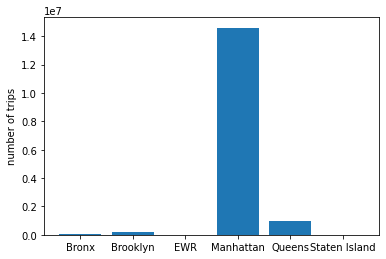

In [23]:
tripByBoro = df.groupby('borough').count()[['DOLocationID']].compute()
plt.bar(tripByBoro.index, tripByBoro.DOLocationID.values)
plt.ylabel('number of trips')

### HW task 1

Compute and Plot 

1. Plot average number of trips as bar plots by day of week
2. Plot average total fare amount by hour of pick up time
3. Average speed by pick up hour (average speed should be calculated as total distance traveled by hour/total travel time by hour. Plot as barplot.
4. Report top 5 and bottom 5 pickup locations in terms of a) total distance, b) average speed

In [24]:
df['dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek

Text(0, 0.5, 'number of trips')

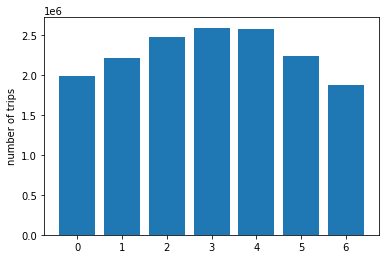

In [25]:
#1. Plot average number of trips as bar plots by day of week
day_of_week= df.groupby('dayofweek').count()[['DOLocationID']].compute()
plt.bar(day_of_week.index, day_of_week.DOLocationID.values)
plt.ylabel('number of trips')

Text(0, 0.5, 'average total fare amount')

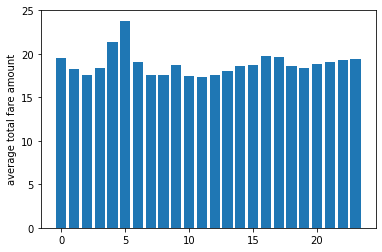

In [26]:
#2. Plot average total fare amount by hour of pick up time
df['hour'] = df['tpep_pickup_datetime'].dt.hour
Hour= df.groupby('hour').mean()[['total_amount']].compute()
plt.bar(Hour.index, Hour.total_amount.values)
plt.ylabel('average total fare amount')

Text(0, 0.5, 'Average speed by pick up hour')

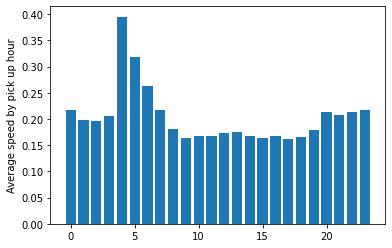

In [34]:
#3. Average speed by pick up hour (average speed should be calculated as total distance traveled by hour/total travel time by hour. Plot as barplot.
Speed= df.groupby('hour').sum()[['trip_distance','travel_time']].compute()
Speed['speed']=Speed['trip_distance']/Speed['travel_time']
plt.bar(Speed.index, Speed.speed.values)
plt.ylabel('Average speed by pick up hour')

In [35]:
#4. Report top 5 and bottom 5 pickup locations in terms of a) total distance, b) average speed
Rank_distance=df.groupby('PULocationID').sum()[['trip_distance']].compute()
Rank_speed=df.groupby('PULocationID').mean()[['trip_distance','travel_time']].compute()

In [43]:
Rank_speed['speed']=Rank_speed['trip_distance']/Rank_speed['travel_time']

In [46]:
Rank_speed=Rank_speed[['speed']]

<AxesSubplot:xlabel='PULocationID'>

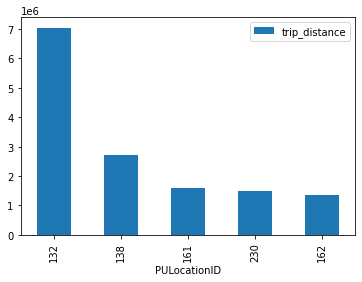

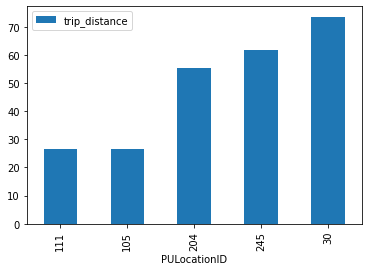

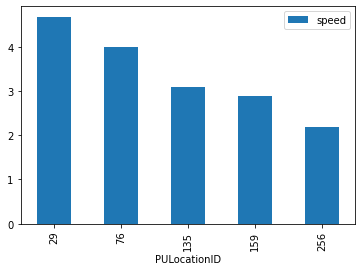

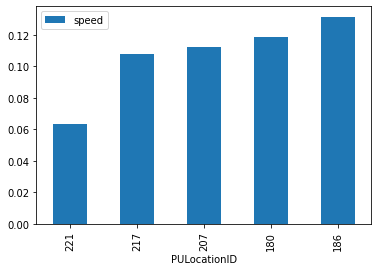

In [48]:
Rank_distance.sort_values(by='trip_distance',ascending=False)[:5].plot(kind='bar',label='top 5 trip_distance')
Rank_distance.sort_values(by='trip_distance',ascending=True)[:5].plot(kind='bar',label='bottom 5 trip_distance')

Rank_speed.sort_values(by='speed',ascending=False)[:5].plot(kind='bar',label='top 5 average speed')
Rank_speed.sort_values(by='speed',ascending=True)[:5].plot(kind='bar',label='bottom 5 average speed')

## Machine learning operations with Dask

### Dask-ML

In [20]:
import dask_ml.datasets
import dask_ml.ensemble

## try linear regression 
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split

X, y = dask_ml.datasets.make_regression(n_samples=1_000_000,
                                        chunks=100_000,
                                        n_features=20)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [21]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [22]:
lr.predict(X)[:5].compute()

array([-115.32621953,  203.98787558,  211.78524798,   49.88895925,
        -91.85589617])

In [23]:
(lr.intercept_, lr.coef_)

(65.20205692805408,
 array([ 2.11778373e-11,  5.95674474e-08,  1.67005474e-07, -1.32395562e-08,
         2.54604528e-08,  7.87848257e+01,  1.03231891e-07,  1.24780447e+01,
         2.71708191e+01,  9.01110170e+01,  2.95555504e-08,  8.59252812e-08,
        -1.19595784e-07,  5.24803131e+01,  7.50879889e+01,  8.13450459e+01,
         9.55763519e+01, -2.55442001e-07,  5.28754926e+01,  1.38622885e-07]))

In [24]:
lr.score(X, y)

0.9999999952646184

In [25]:
# try K-means clustering
import dask_ml.cluster

X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

In [26]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

In [27]:
km.labels_[::1000]

dask.array<getitem, shape=(1000,), dtype=int32, chunksize=(100,), chunktype=numpy.ndarray>

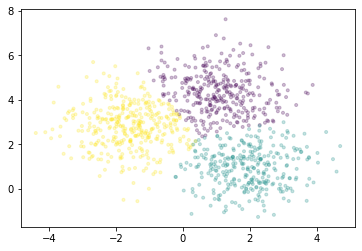

In [28]:
fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],
           cmap='viridis', alpha=0.25);

## Dask_ml for learning average speed in the taxi data

Implement a linear regression of the travel time vs the trip distance

In [29]:
# do some filtering to remove outliers and wrong values
df = df[(df.trip_distance > 0) & (df.trip_distance < 50)]
df = df[(df.total_amount > 0) & (df.total_amount < 300)]
df = df[(df.travel_time > 0) & (df.travel_time < 200)]

In [30]:
lr_taxi = LinearRegression(fit_intercept=False)
lr_taxi.fit(df[['trip_distance']].to_dask_array(),df[['travel_time']].to_dask_array())

LinearRegression(fit_intercept=False)

In [31]:
lr_taxi.coef_ #slope coefficient (min per mile)

array([3.05746554])

In [32]:
dist_sample=df[['trip_distance']].to_dask_array().compute()[:10] #take first 10 distances as a sample

In [33]:
#return the predicted vs actual time for the selected sample
pd.DataFrame({'distance':dist_sample.flatten(), 'predicted time':lr_taxi.predict(dist_sample), 'actual time': df[['travel_time']].to_dask_array().compute()[:10].flatten()})

,distance,predicted time,actual time
0,1.20,3.668959,4.800000
1,1.20,3.668959,7.416667
2,0.60,1.834479,6.183333
3,0.80,2.445972,4.850000
4,0.03,0.091724,0.883333
5,0.70,2.140226,11.450000
6,2.40,7.337917,16.866667
7,0.80,2.445972,14.433333
8,3.30,10.089636,25.283333
9,1.07,3.271488,5.616667


In [34]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [35]:
# do some filtering to remove outliers and wrong values
df = df[(df.trip_distance > 0) & (df.trip_distance < 50)]
df = df[(df.total_amount > 0) & (df.total_amount < 300)]
df = df[(df.travel_time > 0) & (df.travel_time < 200)]

In [36]:
X = df[['trip_distance','travel_time']].values.compute()
y = df.total_amount.values.compute()

Split the data into training and test

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2002)

#### Create Scikit-Learn Pipeline

Pipeline consist of all the models (or intermediate steps) that we wish to train/perform on the data

In [38]:
# make a pipeline - specify the model
pipeline = Pipeline([
    ('lasso', Lasso(fit_intercept=True))])

# specify parameters here we want to optimize
# notice the format - {'model__parameter': range}, this format should follow for all parameters
parameters = {'lasso__alpha': 2.0**(np.arange(-10, 10, 1))}

# call the gridsearch method and fit
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02])},
             verbose=1)

In [39]:
grid_search.best_params_

{'lasso__alpha': 0.0009765625}

In [40]:
# r2 score
grid_search.score(X_test, y_test)

0.8624953522895138

Note: results from scalable scikit learn and dask ml could slightly differ from the simple regression (done with whole data at once) as those operations combine results from different chunks and average them.

### Homework task 2



With trip cost amount as a target variable and using trip distance, travel time and PULocationID as predictors, build a Random Forest Regression with 10 trees (n_estimators) using the sklearn pipeline to select the hyperparameter 'max_depth' with values from 2 to 5.

Use 75:25 train test split as above, use the training data for GridSearchCV with three-fold cross-validation (cv=3). Report the best max_depth as well as the R2 on test data.

In [42]:
# prepare X as features and y as target
X = df[['trip_distance','travel_time','PULocationID']].values.compute()
y = df.total_amount.values.compute()

In [43]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2002)

In [100]:
# create pipeline and fit the model
Pipeline_forest=Pipeline([('random_forest', RandomForestRegressor(n_estimators=10))])

parameters1 = {'random_forest__max_depth': [2,3,4,5]}
# call the gridsearch method and fit
grid_search = GridSearchCV(Pipeline_forest, parameters1, n_jobs=-1, verbose=1, cv=3, refit=True)



In [101]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestRegressor(n_estimators=10))]),
             n_jobs=-1, param_grid={'random_forest__max_depth': [2, 3, 4, 5]},
             verbose=1)

In [102]:
grid_search.best_params_   #the best max_depth=5

{'random_forest__max_depth': 5}

In [103]:
# report test accuracy
grid_search.score(X_test, y_test)

0.8718559414030373